In [5]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification

NOTEBOOK_DIR = pathlib.Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.insert(0, str(PROJECT_ROOT))

CTGAN_LIB = pathlib.Path("/Users/nargiza/PycharmProjects/PythonProject6/latent-tabular-lens")
sys.path.insert(0, str(CTGAN_LIB))


from src.ctgan_adapter import CTGANRepoAdapter
from src.shifter import Shifter, latent_reg, feature_space_reg
from src.diff_mfs import compute_diff_mfs
from src.diff_mfs import compute_diff_mfs
from external.ctgan_repo.ctgan.synthesizers.ctgan_model import CTGAN

DEVICE = "cpu"

In [19]:
# Configuration
N_TRAIN_CTGAN = 2000
N_INFER = 2000
CTGAN_EPOCHS = 100
CTGAN_BATCH_SIZE = 100

META_FEATURES = ["mean"]
SUMMARY = "mean"
TARGET_MEAN = 1.5

TRAIN_STEPS = 100
TRAIN_LR = 3e-4
TRAIN_N_SAMPLES = 400
TRAIN_GRAD_CLIP = 0.5
TRAIN_ACCUM_STEPS = 4

LAMBDA_Z = 0.0
LAMBDA_X = 0.05

target_meta = torch.tensor([TARGET_MEAN], dtype=torch.float32, device=DEVICE)

In [ ]:
# 1. Prepare CTGAN
def make_training_data(n_samples: int, seed: int = 42) -> pd.DataFrame:
    X, y = make_classification(
        n_samples=n_samples, n_features=6, n_informative=6,
        n_redundant=0, n_repeated=0, n_classes=2,
        n_clusters_per_class=1, random_state=seed, class_sep=1.0,
    )
    columns = [f"feat_{i}" for i in range(6)] + ["target"]
    df = pd.DataFrame(np.column_stack([X, y]), columns=columns)
    df["target"] = df["target"].astype(int)
    return df

df_train = make_training_data(N_TRAIN_CTGAN)
print(f"Training CTGAN on {len(df_train)} samples...")

cat_cols = [c for c in df_train.columns
            if df_train[c].dtype == "object"
            or df_train[c].dtype.name == "category"
            or c == "target"]

ctgan = CTGAN(
    epochs=CTGAN_EPOCHS, discriminator_steps=3,
    batch_size=CTGAN_BATCH_SIZE,
    generator_lr=1e-4, discriminator_lr=1e-4, pac=1, cuda=False,
)
ctgan.set_device(DEVICE)
ctgan.fit(train_data=df_train, discrete_columns=cat_cols)

adapter = CTGANRepoAdapter(ctgan)

# Замораживаем параметры генератора для экономии времени
adapter.m._generator.eval()
for p in adapter.m._generator.parameters():
    p.requires_grad_(False)

print(f"z_dim={adapter.z_dim}")

Training CTGAN on 2000 samples...
z_dim=128


In [24]:
# 2. Train Shifter
def compute_loss(shifter, adapter, target_meta, z_dim, Z_base, cond_vec=None):
    """Z → Shifter → CTGAN(diff) → MFE(diff) → MSE + regularizers."""
    Z_tilde = shifter(Z_base.unsqueeze(0), target_meta.unsqueeze(0))
    X_tilde = adapter.generate_from_noise_differentiable(
        Z_tilde.reshape(-1, z_dim), cond_vec=cond_vec,
    )
    meta_tilde, _ = compute_diff_mfs(X_tilde, features=META_FEATURES, summary=SUMMARY)
    
    L_meta = F.mse_loss(meta_tilde, target_meta)
    
    if LAMBDA_Z > 0:
        L_z = latent_reg(Z_tilde, Z_base.unsqueeze(0))
        L_meta = L_meta + LAMBDA_Z * L_z
    if LAMBDA_X > 0:
        X_base = adapter.generate_from_noise_differentiable(
            Z_base.reshape(-1, z_dim), cond_vec=cond_vec,
        )
        L_x = feature_space_reg(X_tilde, X_base)
        L_meta = L_meta + LAMBDA_X * L_x
    
    return L_meta

z_dim = adapter.z_dim
shifter = Shifter(
    z_dim=z_dim, m_dim=target_meta.shape[0],
    c_dim=64, hidden_dim=256, delta_scale=0.1,
).to(DEVICE)

optimizer = optim.Adam(shifter.parameters(), lr=TRAIN_LR)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=TRAIN_STEPS, eta_min=1e-5)


train_log = []
print(f"target={target_meta.cpu().numpy()}, steps={TRAIN_STEPS}, lr={TRAIN_LR}, accum={TRAIN_ACCUM_STEPS}×{TRAIN_N_SAMPLES}")

for step in range(TRAIN_STEPS):
    optimizer.zero_grad()
    total_loss = 0.0
        
    for k in range(TRAIN_ACCUM_STEPS):
        Z_base = torch.randn(TRAIN_N_SAMPLES, z_dim, device=DEVICE)
        cond_vec = adapter.sample_cond_vec(TRAIN_N_SAMPLES)
                
        loss = compute_loss(shifter, adapter, target_meta, z_dim, Z_base, cond_vec)
        (loss / TRAIN_ACCUM_STEPS).backward()
        total_loss += loss.item()

   
    
    avg_loss = total_loss / TRAIN_ACCUM_STEPS
    torch.nn.utils.clip_grad_norm_(shifter.parameters(), max_norm=TRAIN_GRAD_CLIP)
    optimizer.step()
    scheduler.step()
    
    train_log.append({"step": step, "loss": avg_loss, "lr": optimizer.param_groups[0]["lr"]})
    
    if step % 20 == 0 or step == TRAIN_STEPS - 1:
        print(f"step {step:3d}  loss={avg_loss:.6f}  lr={optimizer.param_groups[0]['lr']:.2e}")

target=[1.5], steps=100, lr=0.0003, accum=4×400
step   0  loss=1.289626  lr=3.00e-04
step  20  loss=0.827841  lr=2.70e-04
step  40  loss=0.234110  lr=1.95e-04
step  60  loss=0.176119  lr=1.06e-04
step  80  loss=0.173182  lr=3.51e-05
step  99  loss=0.171822  lr=1.00e-05


In [22]:
# 3. Evaluate
shifter.eval()
with torch.no_grad():
    torch.manual_seed(42)
    Z_base = torch.randn(1, N_INFER, z_dim, device=DEVICE)
    Z_tilde = shifter(Z_base, target_meta.unsqueeze(0))
    
    df_base = adapter.generate_from_noise(Z_base.reshape(-1, z_dim).cpu().numpy())
    df_shifted = adapter.generate_from_noise(Z_tilde.reshape(-1, z_dim).cpu().numpy())
    # Convert DataFrames to tensors, exclude target column 
    X_base = torch.tensor(
        df_base.drop(columns=["target"], errors="ignore")
          .select_dtypes(include=[np.number]).values,
        dtype=torch.float32, device=DEVICE,
    )
    X_shifted = torch.tensor(
        df_shifted.drop(columns=["target"], errors="ignore")
          .select_dtypes(include=[np.number]).values,
        dtype=torch.float32, device=DEVICE,
    )
    
    meta_base, names = compute_diff_mfs(X_base, features=META_FEATURES, summary=SUMMARY)
    meta_shifted, _ = compute_diff_mfs(X_shifted, features=META_FEATURES, summary=SUMMARY)
    
    meta_base_np = meta_base.cpu().numpy()
    meta_shifted_np = meta_shifted.cpu().numpy()

target_np = target_meta.cpu().numpy()
print(f"\n{'Feature':<20s} {'Base':>10s} {'Shifted':>10s} {'Target':>10s}")
print("-" * 54)
for i, name in enumerate(names):
    print(f"{name:<20s} {meta_base_np[i]:>10.4f} {meta_shifted_np[i]:>10.4f} {target_np[i]:>10.4f}")


Feature                    Base    Shifted     Target
------------------------------------------------------
mean.mean                0.3820     1.5713     1.5000


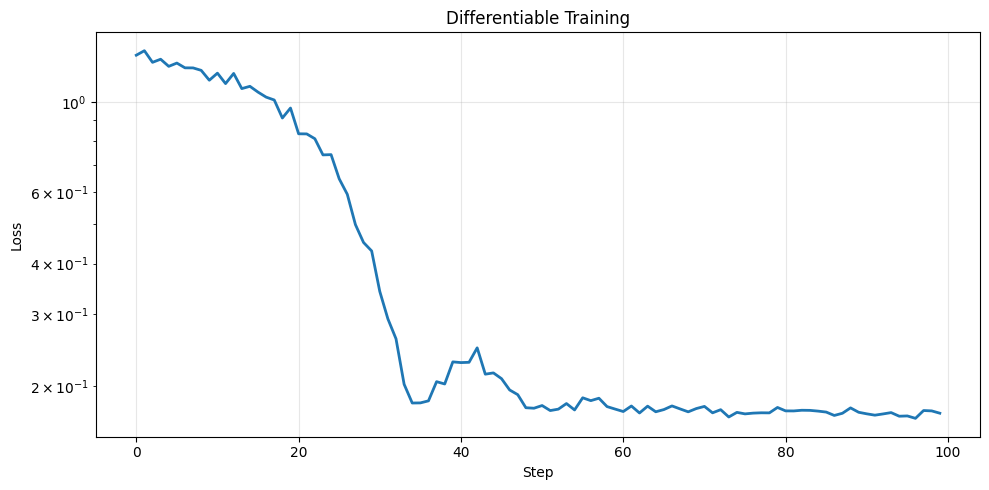

In [23]:
# Training plot
steps = [e["step"] for e in train_log]
losses = [e["loss"] for e in train_log]
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, linewidth=2)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Differentiable Training")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

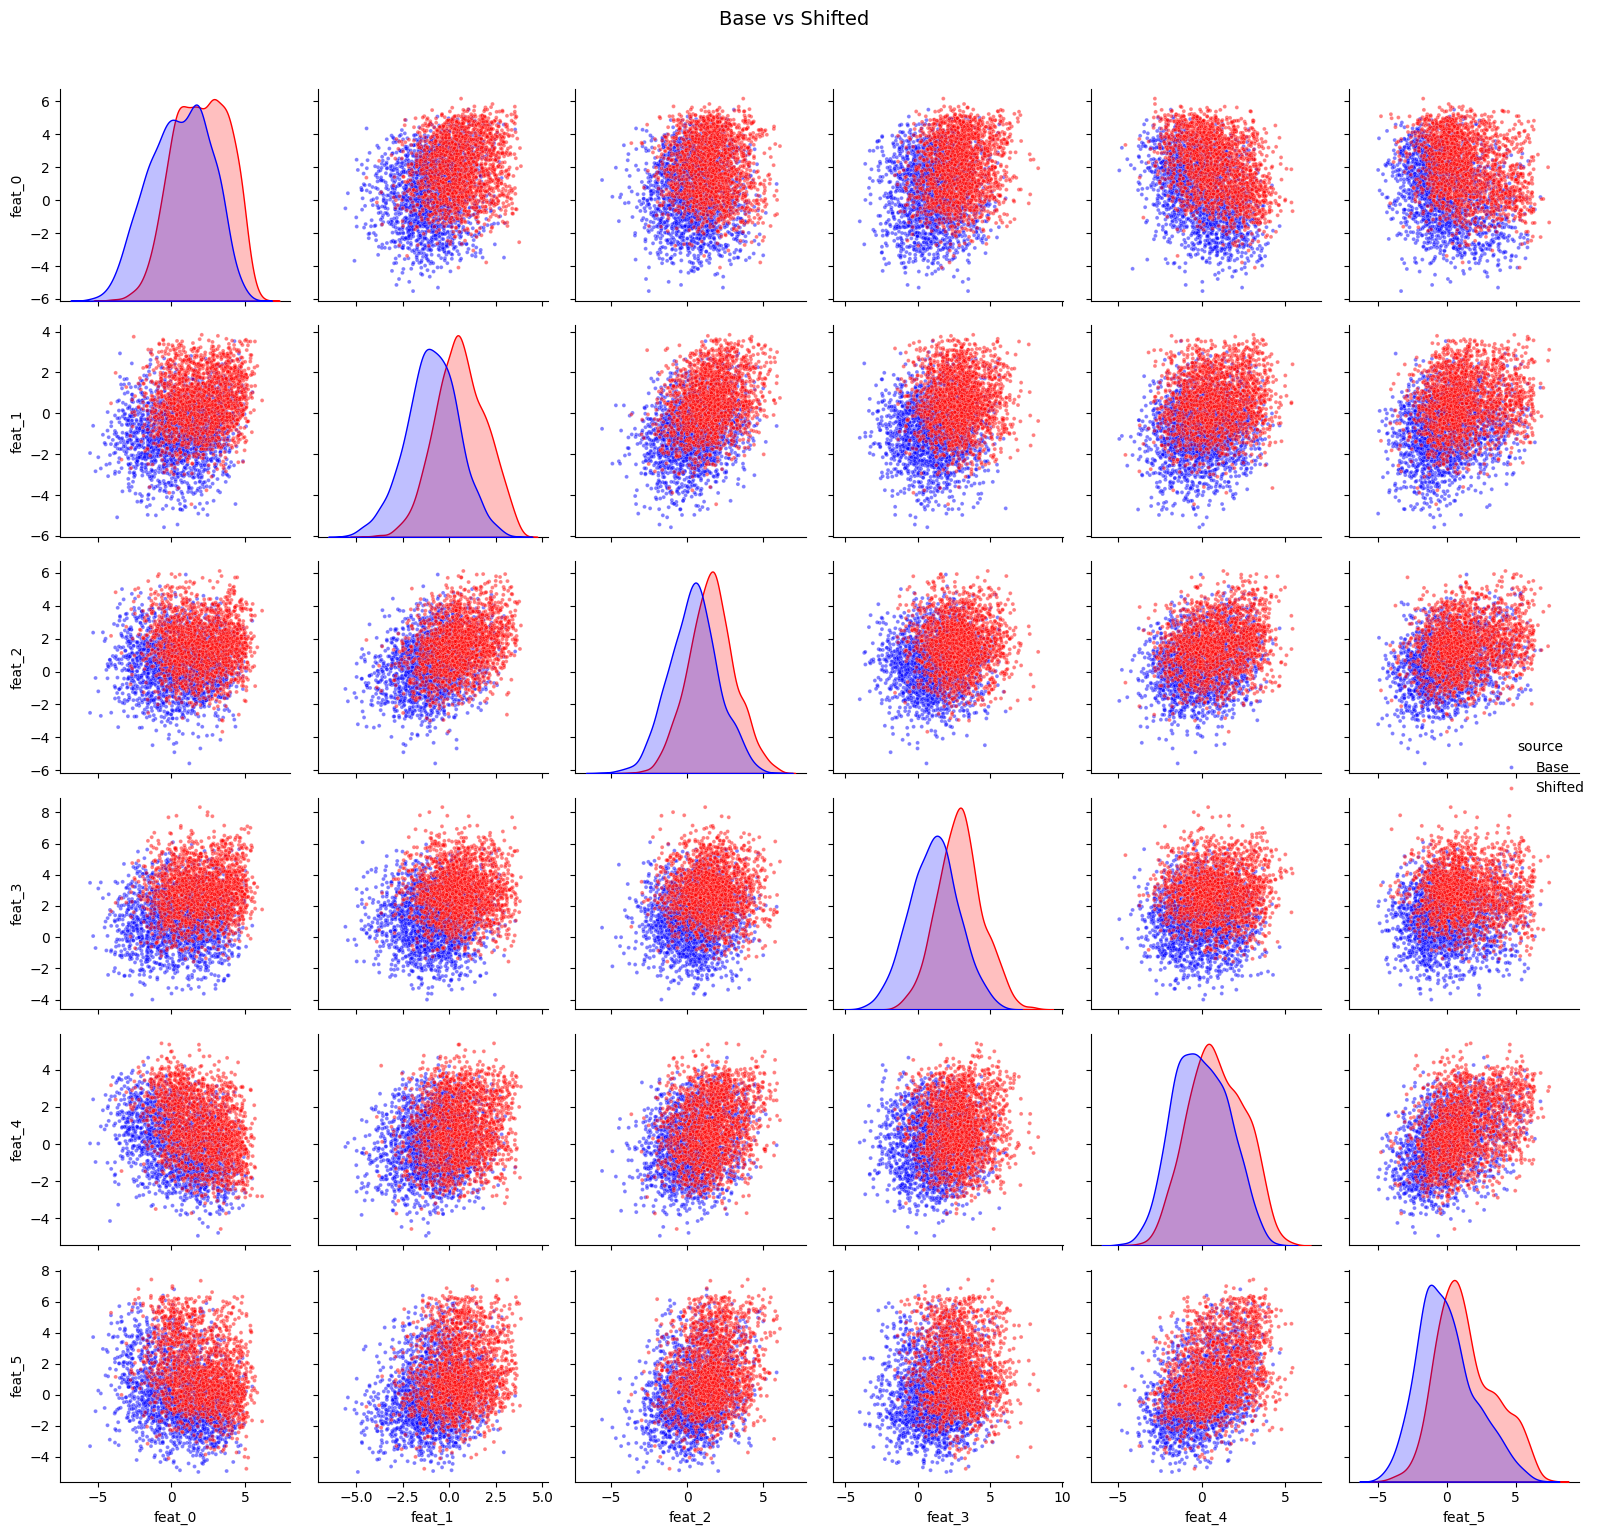

In [18]:
# Pairplot: Base vs Shifted
cols = df_base.select_dtypes(include=[np.number]).columns.tolist()[:6]
b = df_base[cols].head(2000).copy().assign(source="Base")
s = df_shifted[cols].head(2000).copy().assign(source="Shifted")
combined = pd.concat([b, s], ignore_index=True)
sns.pairplot(combined, hue="source", diag_kind="kde",
             plot_kws={"alpha": 0.5, "s": 8},
             palette={"Base": "blue", "Shifted": "red"})
plt.suptitle("Base vs Shifted", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()